# What is my task?

It's funny ... Mr Cj cant understand diffrence from a cat and dog, so he want me to create a model which can predict for him.

# What do i have?

I have a dataset which contains two folders in the PetImages folder, split into 12,499 Cat images in the Cat folder and 12,499 Dog images in the Dog folder.

In this dataset Cats have 0 label and Dogs have 1 label, if you need to [read more](https://www.kaggle.com/competitions/dogs-vs-cats/overview).


# Code

## Import needed libraries

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
from sklearn import metrics
from huggingface_hub import HfApi

RANDOM_SEED = 42
BATCH_SIZE = 32
IMG_SIZE = 150
EPOCHS = 100

MODEL_PATH = Path("./models")
MODEL_FILE_PATH = MODEL_PATH / "cats-vs-dogs.keras"
MODEL_PATH.mkdir(exist_ok=True)


## Download dataset

In [2]:
dataset, info = tfds.load(
    name='cats_vs_dogs',
    split="train", # seems like dataset has only train part
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
)

## Understand dataset

### Get some info about dataset

In [3]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

In [4]:
print(f"dataset size is '{len(dataset)}'\n")

i = 0
for image, label in dataset.take(3):
  print(f"image {i} shape is '{image.shape}'")
  print(f"image {i} label is '{label}'")
  print(f"sample image pixel '{image[0, 0, 0]}'")
  print()
  i += 1

dataset size is '23262'

image 0 shape is '(500, 345, 3)'
image 0 label is '1'
sample image pixel '136'

image 1 shape is '(375, 500, 3)'
image 1 label is '1'
sample image pixel '57'

image 2 shape is '(375, 500, 3)'
image 2 label is '0'
sample image pixel '27'



In [5]:
dogs = 0
cats = 0

for _, label in dataset:
  if label == 0:
    cats += 1
  else:
    dogs += 1

print(f"dogs count: {dogs}, cats count: {cats}")

dogs count: 11604, cats count: 11658


### Plot some images with label

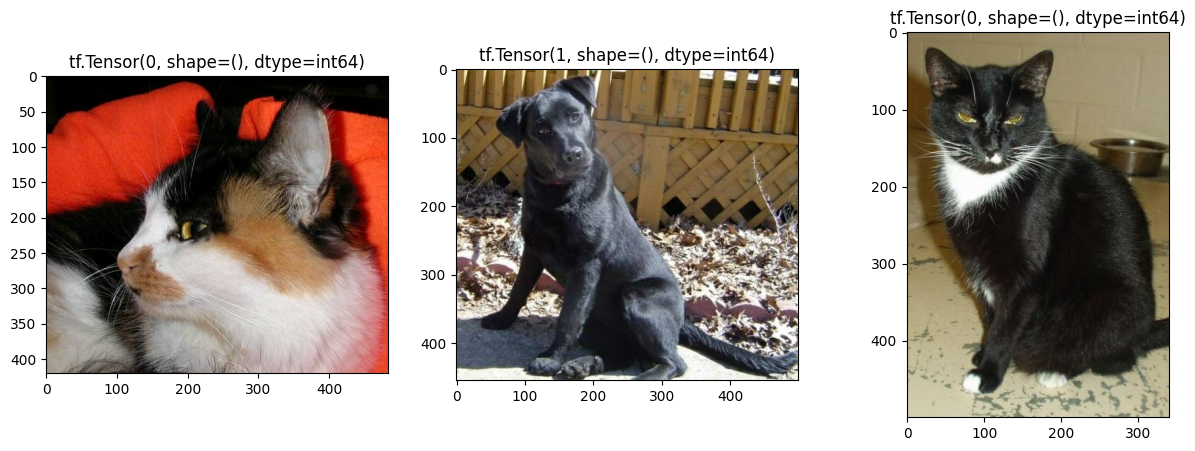

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

i = 0
for image, label in dataset.take(3):
 axes[i].imshow(image)
 axes[i].set_title(label)
 i+=1

plt.show()

## Split dataset into train and test

In [7]:
train_split_ratio = 0.8  # 80% for training, 20% for testing
dataset_size = info.splits['train'].num_examples
train_size = int(train_split_ratio * dataset_size)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

len(train_ds), len(test_ds)

(18609, 4653)

Good now we have *18609* train images and *4653* test images.

## Preprocess

Our pixel values are not between 0 and 1. they are int8 values between 0 and 255. Our images are also not in fixed size, So we Need to resize images.

**Note**: `EfficientNetB0` has a rescale layer so we don't need to rescale pixels.


In [8]:
def preprocess(image, label, image_size=(IMG_SIZE, IMG_SIZE)):
  """
      Preprocess images, we get image and ...
        1. resize it to given size
        2. cat image pixels type into float32
        3. rescale it pixels into 0 and 1
  """
  image = tf.image.resize(image, image_size)
  return image, label

In [9]:
# Note: you must assigning it back to variable!
train_ds = train_ds.map(preprocess).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

So we setup the preprocess function, now time for model to come ...

## Model

Im going to fine-tune `EfficientNetB0` I'll also add some layers.

### Setup model architecture

In [10]:
effnet0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classes=2,
    name="efficientnetb0",
)
effnet0.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), batch_size=BATCH_SIZE)

# The EfficientNetB0 layers must be trainable
effnet0.trainable = True

X = effnet0(input)
X = tf.keras.layers.GlobalAveragePooling2D()(X)
X = tf.keras.layers.Dense(units=100, activation="relu")(X)
X = tf.keras.layers.Dense(units=1, activation="sigmoid")(X)

effnet0_model = tf.keras.Model(inputs=input, outputs=X) # Correct model instantiation

In [12]:
effnet0_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (32, 150, 150, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (32, 5, 5, 1280)       │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (32, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 100)              │       128,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177,772 (15.94 MB)

 Trainable params: 4,135,749 (15.78 MB)

 Non-trainable params: 42,023 (164.16 KB)

### Setup model hyper parameters

In [13]:
optim = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy()

In [14]:
earlyStop_ch = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=0
)

checkPoint_cb = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILE_PATH,
    monitor="val_loss",
    save_best_only=True,
    verbose=0
)

callbacks = [earlyStop_ch, checkPoint_cb]

### Compile and fit model

In [15]:
effnet0_model.compile(
    optimizer=optim, loss=loss, metrics=["accuracy"]
)

In [16]:
hist = effnet0_model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 241s 252ms/step - accuracy: 0.8864 - loss: 0.2730 - val_accuracy: 0.9819 - val_loss: 0.0543
Epoch 2/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 73s 123ms/step - accuracy: 0.9772 - loss: 0.0583 - val_accuracy: 0.9869 - val_loss: 0.0405
Epoch 3/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - accuracy: 0.9888 - loss: 0.0313 - val_accuracy: 0.9858 - val_loss: 0.0423
Epoch 4/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 91s 155ms/step - accuracy: 0.9924 - loss: 0.0230 - val_accuracy: 0.9886 - val_loss: 0.0333
Epoch 5/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 71s 118ms/step - accuracy: 0.9947 - loss: 0.0153 - val_accuracy: 0.9873 - val_loss: 0.0409
Epoch 6/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 72s 121ms/step - accuracy: 0.9964 - loss: 0.0100 - val_accuracy: 0.9893 - val_loss: 0.0382
Epoch 7/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 75s 125ms/step - accuracy: 0.9984 - loss: 0.0068 - val_accuracy: 0.9901 - val_loss: 0.0363


I can smell a little overfit.

In [20]:
effnet0_model.evaluate(test_ds)

146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9900 - loss: 0.0359


[0.03628823161125183, 0.9901139140129089]

In [21]:
model = tf.keras.models.load_model(MODEL_FILE_PATH)

## Evaluate model

In [22]:
model.evaluate(test_ds)

146/146 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.9887 - loss: 0.0332


[0.03343818336725235, 0.988394558429718]

### Plot model results

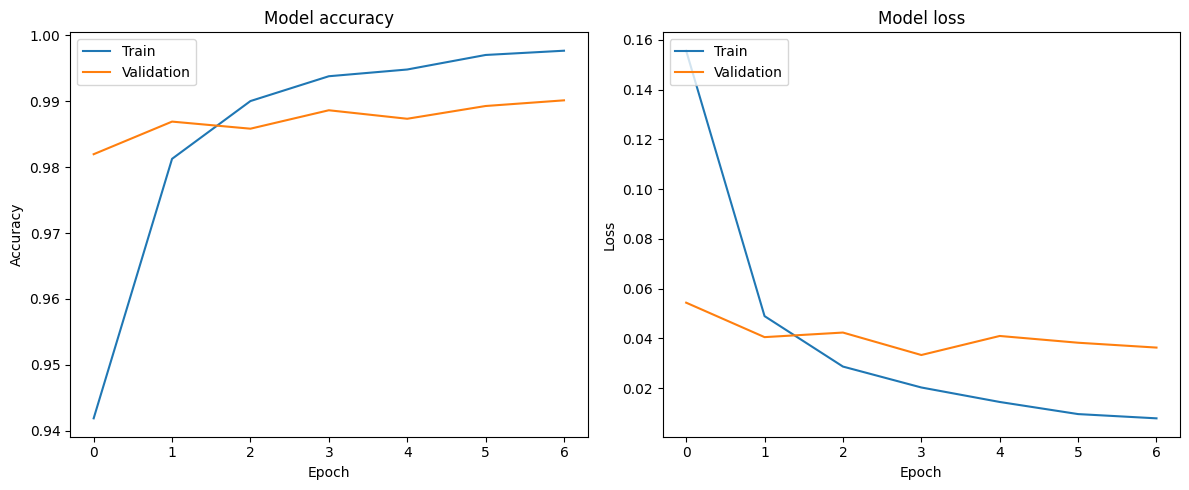

In [23]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Evaluation scores

In [31]:
y_true_list = []
y_pred_list = []

# Iterate over the entire test_ds
for img_batch, label_batch in test_ds:
  predictions = model.predict(img_batch)

  # Convert probabilities to binary predictions (0 or 1) using a 0.5 threshold
  binary_predictions = (predictions >= 0.5).astype(int)

  y_true_list.append(label_batch.numpy())
  y_pred_list.append(binary_predictions)

# Concatenate all true labels and predictions into 1D arrays
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

In [ ]:
y_true

In [32]:
print(metrics.classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2273
           1       0.99      0.99      0.99      2380

    accuracy                           0.99      4653
   macro avg       0.99      0.99      0.99      4653
weighted avg       0.99      0.99      0.99      4653



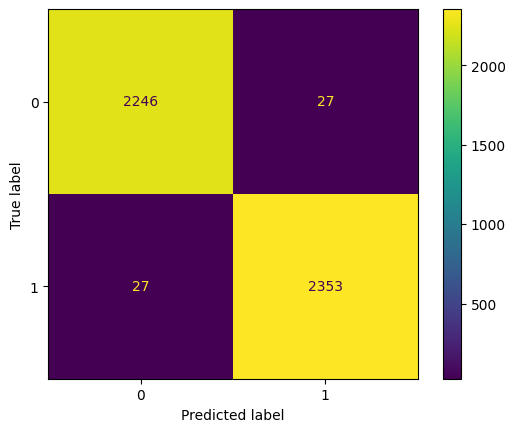

In [33]:
metrics.ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true)

## Save model in hugging face

In [34]:
api = HfApi()
api.upload_file(
    path_or_fileobj=MODEL_FILE_PATH,
    repo_id="sirunchained/cats-vs-dogs",
    path_in_repo="cats-vs-dogs.keras"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  models/cats-vs-dogs.keras   :  66%|######5   | 33.5MB / 50.8MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sirunchained/cats-vs-dogs/commit/33bc5b966ce3fd2449caf38260784b9731e9801d', commit_message='Upload cats-vs-dogs.keras with huggingface_hub', commit_description='', oid='33bc5b966ce3fd2449caf38260784b9731e9801d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sirunchained/cats-vs-dogs', endpoint='https://huggingface.co', repo_type='model', repo_id='sirunchained/cats-vs-dogs'), pr_revision=None, pr_num=None)

## Setup Gradio client

In [35]:
import numpy as np
import tensorflow as tf
from PIL import Image
import gradio as gr
from huggingface_hub import hf_hub_download

classes = ["Cat", "Dog"]

model_path = hf_hub_download(
    repo_id="sirunchained/cats-vs-dogs",
    filename="cats-vs-dogs.keras"
)

model = tf.keras.models.load_model(model_path)

def predict_img(img):
  """
  Predict image is a dog or cat
  """

  img = img.resize((150, 150))
  img = np.array(img)

  img = tf.expand_dims(img, axis=0)
  img = tf.cast(img, tf.float32)

  predictions = model.predict(img)
  predicted_confidences = predictions[0]

  result = {classes[i]: float(predicted_confidences[0]) for i in range(len(classes))}

  return result

iface = gr.Interface(
    fn=predict_img,
    inputs=gr.Image(type="pil", label="Upload Food Image"),
    outputs=gr.Label(num_top_classes=2, label="Prediction"),
    title="Cats vs Dogs Classifier with EfficientNetB0",
    description="Upload an image to get its predicted category and confidence."
)

iface.launch(
    debug=True
)

cats-vs-dogs.keras:   0%|          | 0.00/50.8M [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4c402f72dab6011b01.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4c402f72dab6011b01.gradio.live
